# Part 2: Modelling

#### In part 2 we will train machine learning models to see what factors are leading to Churn.
#### We use tidymodels packages like parsnip, recipes, tune, dials, yardstick to create models.

## Accuracy vs Interpretability Tradeoff

#### Linear models are more interpretable but usually are not very accurate.
#### We will examine both linear model and a more complex model like xgboost in Part 2.

In [1]:
library(tidyverse)
library(tidymodels)
library(tidyquant)
library(glmnet)
library(caret)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
── Attaching packages ────────────────────────────────────── tidymodels 0.1.0 ──
✔ broom     0.5.5      ✔ rsample   0.0.5 
✔ dials     0.0.4      ✔ tune      0.0.1 
✔ infer     0.5.1      ✔ workflows 0.1.1 
✔ parsnip   0.0.5      ✔ yardstick 0.0.6 
✔ recipes   0.1.10     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ re

In [2]:
df <- read_csv('telco_customer_churn.csv', col_types = cols(customerID = col_skip()))
df <- df %>% 
        mutate_if(is.character, as_factor) 
       #%>% mutate(Churn = Churn %>% fct_relevel('Yes'))
        
glimpse(df)

Observations: 7,043
Variables: 20
$ gender           <fct> Female, Male, Male, Male, Female, Female, Male, Fema…
$ SeniorCitizen    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ Partner          <fct> Yes, No, No, No, No, No, No, No, Yes, No, Yes, No, Y…
$ Dependents       <fct> No, No, No, No, No, No, Yes, No, No, Yes, Yes, No, N…
$ tenure           <dbl> 1, 34, 2, 45, 2, 8, 22, 10, 28, 62, 13, 16, 58, 49, …
$ PhoneService     <fct> No, Yes, Yes, No, Yes, Yes, Yes, No, Yes, Yes, Yes, …
$ MultipleLines    <fct> No phone service, No, No, No phone service, No, Yes,…
$ InternetService  <fct> DSL, DSL, DSL, DSL, Fiber optic, Fiber optic, Fiber …
$ OnlineSecurity   <fct> No, Yes, Yes, Yes, No, No, No, Yes, No, Yes, Yes, No…
$ OnlineBackup     <fct> Yes, No, Yes, No, No, No, Yes, No, No, Yes, No, No i…
$ DeviceProtection <fct> No, Yes, No, Yes, No, Yes, No, No, Yes, No, No, No i…
$ TechSupport      <fct> No, No, No, Yes, No, No, No, No, Yes, No, No, No int…
$ StreamingTV     

In [3]:
df$Churn %>% levels

[1] "No"  "Yes"

In [4]:
split_obj <- rsample::initial_split(df, prop = 0.8, strata = 'Churn')

In [5]:
train = rsample::training(split_obj)
test = rsample::testing(split_obj)

In [6]:
table(test$Churn)


  No  Yes 
1034  373 

In [7]:
1-(373/1034)

[1] 0.639265

#### Our baseline accuracy is 0.64.

In [8]:
# We get vector of columns to drop from EDA done before.
drop_cols_2 <- readRDS('drop_cols_2.rds')
drop_cols_2

[1] "gender_Female"                       
 [2] "Partner_No"                          
 [3] "Dependents_No"                       
 [4] "PhoneService_No"                     
 [5] "MultipleLines_No.phone.service"      
 [6] "MultipleLines_No"                    
 [7] "InternetService_No"                  
 [8] "OnlineSecurity_Yes"                  
 [9] "OnlineSecurity_No.internet.service"  
[10] "OnlineBackup_Yes"                    
[11] "OnlineBackup_No.internet.service"    
[12] "DeviceProtection_Yes"                
[13] "DeviceProtection_No.internet.service"
[14] "TechSupport_Yes"                     
[15] "TechSupport_No.internet.service"     
[16] "StreamingTV_No"                      
[17] "StreamingTV_No.internet.service"     
[18] "StreamingMovies_No"                  
[19] "StreamingMovies_No.internet.service" 
[20] "Contract_One.year"                   
[21] "PaperlessBilling_No"                 
[22] "PaymentMethod_Mailed.check"          
[23] "MonthlyCharges"                      
[24] "TotalCharges"

In [9]:
recipe_obj <- df %>% 
    recipe(Churn ~ ., data = df) %>%
    step_knnimpute(TotalCharges) %>% 
    step_YeoJohnson(all_numeric()) %>%
    step_center(all_numeric()) %>% 
    step_scale(all_numeric()) %>%
    step_mutate(SeniorCitizen = SeniorCitizen %>% as.numeric()) %>% 
    step_dummy(all_nominal(), -Churn, one_hot = T) %>% 
    step_rm(drop_cols_2)

In [10]:
train_processed <- recipe_obj %>% prep() %>% bake(train)
test_processed <- recipe_obj %>% prep() %>% bake(test)

train_processed %>% glimpse()

Observations: 5,636
Variables: 22
$ SeniorCitizen                           <dbl> -0.4398853, -0.4398853, -0.43…
$ tenure                                  <dbl> -1.64422287, 0.29718222, -1.4…
$ Churn                                   <fct> No, No, Yes, No, Yes, Yes, No…
$ gender_Male                             <dbl> 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,…
$ Partner_Yes                             <dbl> 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,…
$ Dependents_Yes                          <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,…
$ PhoneService_Yes                        <dbl> 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,…
$ MultipleLines_Yes                       <dbl> 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,…
$ InternetService_DSL                     <dbl> 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,…
$ InternetService_Fiber.optic             <dbl> 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,…
$ OnlineSecurity_No                       <dbl> 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,…
$ OnlineBackup_No                         <dbl> 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,…
$ DeviceProtection

In [11]:
x = as.matrix(train_processed %>% select(-Churn))
y = train_processed$Churn
model_1 <- cv.glmnet(x, y, family = 'binomial')

In [12]:
model_1 %>% attributes

$names
 [1] "lambda"     "cvm"        "cvsd"       "cvup"       "cvlo"      
 [6] "nzero"      "call"       "name"       "glmnet.fit" "lambda.min"
[11] "lambda.1se"

$class
[1] "cv.glmnet"

In [13]:
model_1$lambda.min

[1] 0.001164273

In [14]:
tmp_coeffs <- coef(model_1, s = "lambda.min")
tmp_coeffs

22 x 1 sparse Matrix of class "dgCMatrix"
                                                   1
(Intercept)                             -2.813381797
SeniorCitizen                            0.097030680
tenure                                  -0.877934027
gender_Male                             -0.001269805
Partner_Yes                              0.078310289
Dependents_Yes                          -0.097735098
PhoneService_Yes                        -0.452663982
MultipleLines_Yes                        0.316840359
InternetService_DSL                      .          
InternetService_Fiber.optic              0.924093617
OnlineSecurity_No                        0.345838571
OnlineBackup_No                          0.087771820
DeviceProtection_No                      .          
TechSupport_No                           0.287781934
StreamingTV_Yes                          0.280765636
StreamingMovies_Yes                      0.303612372
Contract_Month.to.month                  0.635783231
Cont

In [15]:
tmp_coeffs@i

[1]  0  1  2  3  4  5  6  7  9 10 11 13 14 15 16 17 18 19 20 21

In [16]:
tmp_coeffs %>% attributes

$i
 [1]  0  1  2  3  4  5  6  7  9 10 11 13 14 15 16 17 18 19 20 21

$p
[1]  0 20

$Dim
[1] 22  1

$Dimnames
$Dimnames[[1]]
 [1] "(Intercept)"                            
 [2] "SeniorCitizen"                          
 [3] "tenure"                                 
 [4] "gender_Male"                            
 [5] "Partner_Yes"                            
 [6] "Dependents_Yes"                         
 [7] "PhoneService_Yes"                       
 [8] "MultipleLines_Yes"                      
 [9] "InternetService_DSL"                    
[10] "InternetService_Fiber.optic"            
[11] "OnlineSecurity_No"                      
[12] "OnlineBackup_No"                        
[13] "DeviceProtection_No"                    
[14] "TechSupport_No"                         
[15] "StreamingTV_Yes"                        
[16] "StreamingMovies_Yes"                    
[17] "Contract_Month.to.month"                
[18] "Contract_Two.year"                      
[19] "PaperlessBilling_Yes"                   
[20] "PaymentMethod_Electronic.check"         
[21] "PaymentMethod_Bank.transfer..automatic."
[22] "PaymentMethod_Credit.card..automatic."  

$Dimnames[[2]]
[1] "1"


$x
 [1] -2.813381797  0.097030680 -0.877934027 -0.001269805  0.078310289
 [6] -0.097735098 -0.452663982  0.316840359  0.924093617  0.345838571
[11]  0.087771820  0.287781934  0.280765636  0.303612372  0.635783231
[16] -0.689084468  0.323608060  0.328640347  0.083212398 -0.077445360

$factors
list()

$class
[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

In [17]:
tmp_coeffs@Dimnames

[[1]]
 [1] "(Intercept)"                            
 [2] "SeniorCitizen"                          
 [3] "tenure"                                 
 [4] "gender_Male"                            
 [5] "Partner_Yes"                            
 [6] "Dependents_Yes"                         
 [7] "PhoneService_Yes"                       
 [8] "MultipleLines_Yes"                      
 [9] "InternetService_DSL"                    
[10] "InternetService_Fiber.optic"            
[11] "OnlineSecurity_No"                      
[12] "OnlineBackup_No"                        
[13] "DeviceProtection_No"                    
[14] "TechSupport_No"                         
[15] "StreamingTV_Yes"                        
[16] "StreamingMovies_Yes"                    
[17] "Contract_Month.to.month"                
[18] "Contract_Two.year"                      
[19] "PaperlessBilling_Yes"                   
[20] "PaymentMethod_Electronic.check"         
[21] "PaymentMethod_Bank.transfer..automatic."
[22] "PaymentMethod_Credit.card..automatic."  

[[2]]
[1] "1"

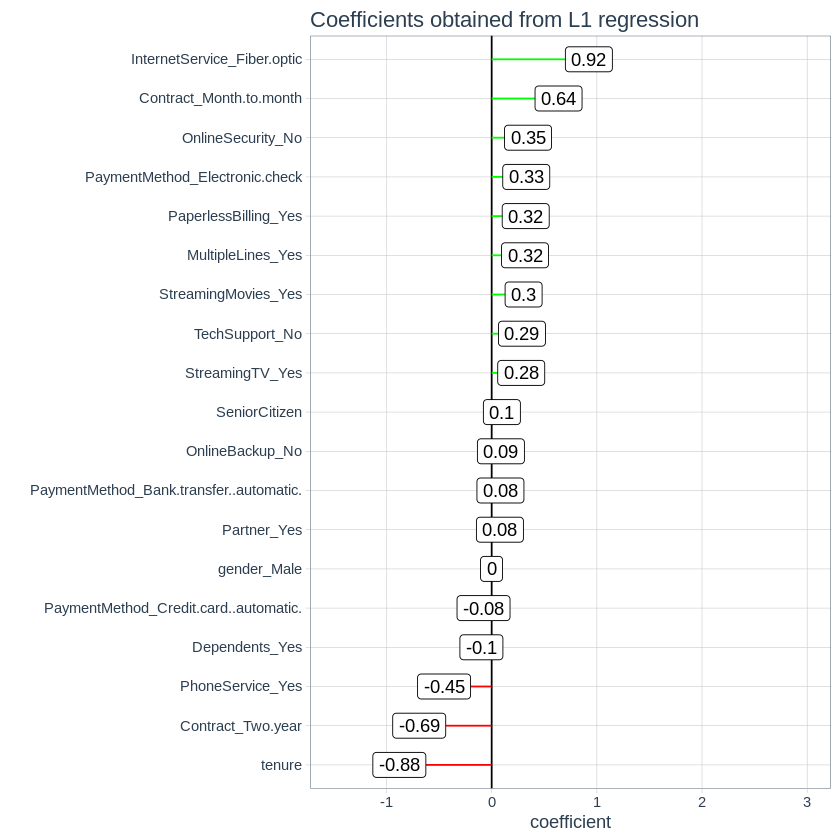

In [18]:
coeffs <- tibble(name = tmp_coeffs@Dimnames[[1]][tmp_coeffs@i + 1], coefficient = tmp_coeffs@x)%>% filter(name != '(Intercept)')

coeffs %>%
    mutate(name = name %>% as_factor() %>% fct_reorder(coefficient)) %>% 
    ggplot(aes(x = coefficient, y = name)) +
    geom_vline(xintercept = 0) +
    geom_segment(aes(yend = name, xend = 0), color = ifelse(coeffs$coefficient >= 0 , 'green', 'red')) +
    geom_label(aes(label = round(coefficient, 2))) +
    expand_limits(x = c(-1.5,3)) +
    theme_tq()+
    labs(title = 'Coefficients obtained from L1 regression', y = '')

#### The results are similar to correlation analysis.

In [19]:
metric_set_class <- metric_set(accuracy, bal_accuracy, f_meas, yardstick::precision, yardstick::recall)
metric_set_prob <- metric_set(roc_auc, pr_auc, average_precision, mn_log_loss )

In [20]:
x_test = as.matrix(test_processed %>% select(-Churn))
y_test = test_processed %>% select(Churn)

y_pred_prob =predict(model_1, x_test) %>% 
                    as_tibble %>% 
                    set_names(c('pred'))
y_pred_class = y_pred_prob %>% 
                    mutate(pred = as_factor(case_when(pred >= 0.5 ~ 'Yes',
                                                      TRUE ~ 'No')))

bind_cols(y_test,y_pred_class)  %>% metric_set_class(truth = Churn, estimate = pred)

.metric,.estimator,.estimate
accuracy,binary,0.7882018
bal_accuracy,binary,0.6279577
f_meas,binary,0.8705474
precision,binary,0.7902208
recall,binary,0.9690522


In [21]:
bind_cols(y_test, y_pred_prob) %>%
    mutate(Churn = Churn %>% fct_relevel('Yes')) %>% 
    metric_set_prob(Churn, pred)

.metric,.estimator,.estimate
roc_auc,binary,0.8562494
pr_auc,binary,0.6769443
average_precision,binary,0.6768340
mn_log_loss,binary,5.2221581


In [22]:
# Why does the below code not work??
# See documentation. The arguments for class ones are truth , estimate but for prob it is truth , ...

# bind_cols(y_test, y_pred_prob) %>%
#     mutate(Churn = Churn %>% fct_relevel('Yes')) %>% 
#     metric_set_prob(truth = Churn, estimate = pred)

In [23]:
xgboost_model <- boost_tree(
        mode       = "classification", 
        trees      = 1000, 
        min_n      = tune(), 
        tree_depth = tune(), 
        learn_rate = tune()
    ) %>%
    set_engine("xgboost")

In [24]:
xgboost_params <- parameters(min_n(), tree_depth(), learn_rate())
xgboost_grid <- grid_max_entropy(xgboost_params, size = 30)
xgboost_grid

min_n,tree_depth,learn_rate
40,11,4.683094e-10
39,14,3.446674e-04
11,4,9.037702e-07
30,12,2.546164e-08
4,15,1.320845e-04
15,7,7.194174e-08
15,7,1.162413e-04
13,8,2.428912e-02
17,12,1.045901e-04
26,2,5.269393e-02


In [25]:
folds <- rsample::vfold_cv(data = train, v=5, strata = 'Churn')
ctrl <- control_grid(verbose = TRUE)

xgboost_cv_results <-
  tune_grid(
    recipe_obj,
    model = xgboost_model,
    resamples = folds,
    grid = xgboost_grid,
    metrics = metric_set(roc_auc),
    control = ctrl
  )

i Fold1: recipe
✓ Fold1: recipe
i Fold1: model  1/30
✓ Fold1: model  1/30
i Fold1: model  1/30 (predictions)
i Fold1: model  2/30
✓ Fold1: model  2/30
i Fold1: model  2/30 (predictions)
i Fold1: model  3/30
✓ Fold1: model  3/30
i Fold1: model  3/30 (predictions)
i Fold1: model  4/30
✓ Fold1: model  4/30
i Fold1: model  4/30 (predictions)
i Fold1: model  5/30
✓ Fold1: model  5/30
i Fold1: model  5/30 (predictions)
i Fold1: model  6/30
✓ Fold1: model  6/30
i Fold1: model  6/30 (predictions)
i Fold1: model  7/30
✓ Fold1: model  7/30
i Fold1: model  7/30 (predictions)
i Fold1: model  8/30
✓ Fold1: model  8/30
i Fold1: model  8/30 (predictions)
i Fold1: model  9/30
✓ Fold1: model  9/30
i Fold1: model  9/30 (predictions)
i Fold1: model 10/30
✓ Fold1: model 10/30
i Fold1: model 10/30 (predictions)
i Fold1: model 11/30
✓ Fold1: model 11/30
i Fold1: model 11/30 (predictions)
i Fold1: model 12/30
✓ Fold1: model 12/30
i Fold1: model 12/30 (predictions)
i Fold1: model 13/30
✓ Fold1: model 13/30
i 

i Fold4: model 16/30
✓ Fold4: model 16/30
i Fold4: model 16/30 (predictions)
i Fold4: model 17/30
✓ Fold4: model 17/30
i Fold4: model 17/30 (predictions)
i Fold4: model 18/30
✓ Fold4: model 18/30
i Fold4: model 18/30 (predictions)
i Fold4: model 19/30
✓ Fold4: model 19/30
i Fold4: model 19/30 (predictions)
i Fold4: model 20/30
✓ Fold4: model 20/30
i Fold4: model 20/30 (predictions)
i Fold4: model 21/30
✓ Fold4: model 21/30
i Fold4: model 21/30 (predictions)
i Fold4: model 22/30
✓ Fold4: model 22/30
i Fold4: model 22/30 (predictions)
i Fold4: model 23/30
✓ Fold4: model 23/30
i Fold4: model 23/30 (predictions)
i Fold4: model 24/30
✓ Fold4: model 24/30
i Fold4: model 24/30 (predictions)
i Fold4: model 25/30
✓ Fold4: model 25/30
i Fold4: model 25/30 (predictions)
i Fold4: model 26/30
✓ Fold4: model 26/30
i Fold4: model 26/30 (predictions)
i Fold4: model 27/30
✓ Fold4: model 27/30
i Fold4: model 27/30 (predictions)
i Fold4: model 28/30
✓ Fold4: model 28/30
i Fold4: model 28/30 (predictions)

In [26]:
xgboost_cv_results %>% show_best()

min_n,tree_depth,learn_rate,.metric,.estimator,mean,n,std_err
26,2,0.0526939324,roc_auc,binary,0.8427290,5,0.002716800
34,8,0.0104660303,roc_auc,binary,0.8408625,5,0.003844881
36,13,0.0176658398,roc_auc,binary,0.8380296,5,0.003338415
39,14,0.0003446674,roc_auc,binary,0.8330840,5,0.004420917
7,3,0.0451139392,roc_auc,binary,0.8326058,5,0.002762381


In [27]:
params_xgboost_best <- xgboost_cv_results %>% select_best()
params_xgboost_best

min_n,tree_depth,learn_rate
26,2,0.05269393


In [28]:
xgboost_model_final <- xgboost_model %>% finalize_model(params_xgboost_best) %>% 
                                fit(Churn ~ ., data = train_processed)
            
xgboost_model_final

parsnip model object

Fit time:  2.2s 
##### xgb.Booster
raw: 378.1 Kb 
call:
  xgboost::xgb.train(params = list(eta = 0.052693932391208, max_depth = 2L, 
    gamma = 0, colsample_bytree = 1, min_child_weight = 26L, 
    subsample = 1), data = x, nrounds = 1000, verbose = 0, objective = "binary:logistic", 
    nthread = 1)
params (as set within xgb.train):
  eta = "0.052693932391208", max_depth = "2", gamma = "0", colsample_bytree = "1", min_child_weight = "26", subsample = "1", objective = "binary:logistic", nthread = "1", silent = "1"
xgb.attributes:
  niter
# of features: 21 
niter: 1000
nfeatures : 21 

In [29]:
calc_test_metrics <- function(model, data = test_processed){
    
    class_metrics <- model %>% 
    predict(data) %>%  
    bind_cols(data %>% select(Churn))  %>%
    metric_set_class(truth = Churn, estimate = .pred_class)
    
    prob_metrics <- model %>% 
    predict(data, type = 'prob') %>%  
    bind_cols(data %>% select(Churn))  %>%
    metric_set_prob(truth = Churn, .pred_Yes)
    
    return(bind_rows(class_metrics, prob_metrics))
    
}

In [30]:
xgboost_model_final %>% 
    predict(test_processed) %>% 
    bind_cols(test_processed %>% select(Churn)) %>% 
    metric_set_class(truth = Churn, estimate = .pred_class)

.metric,.estimator,.estimate
accuracy,binary,0.8144989
bal_accuracy,binary,0.7264002
f_meas,binary,0.8786611
precision,binary,0.8460161
recall,binary,0.9139265


In [31]:
calc_test_metrics(xgboost_model_final)

.metric,.estimator,.estimate
accuracy,binary,0.8144989
bal_accuracy,binary,0.7264002
f_meas,binary,0.8786611
precision,binary,0.8460161
recall,binary,0.9139265
roc_auc,binary,0.8552538
pr_auc,binary,0.5557709
average_precision,binary,0.5564040
mn_log_loss,binary,2.1116719


#### Xgboost is much better than glmnet

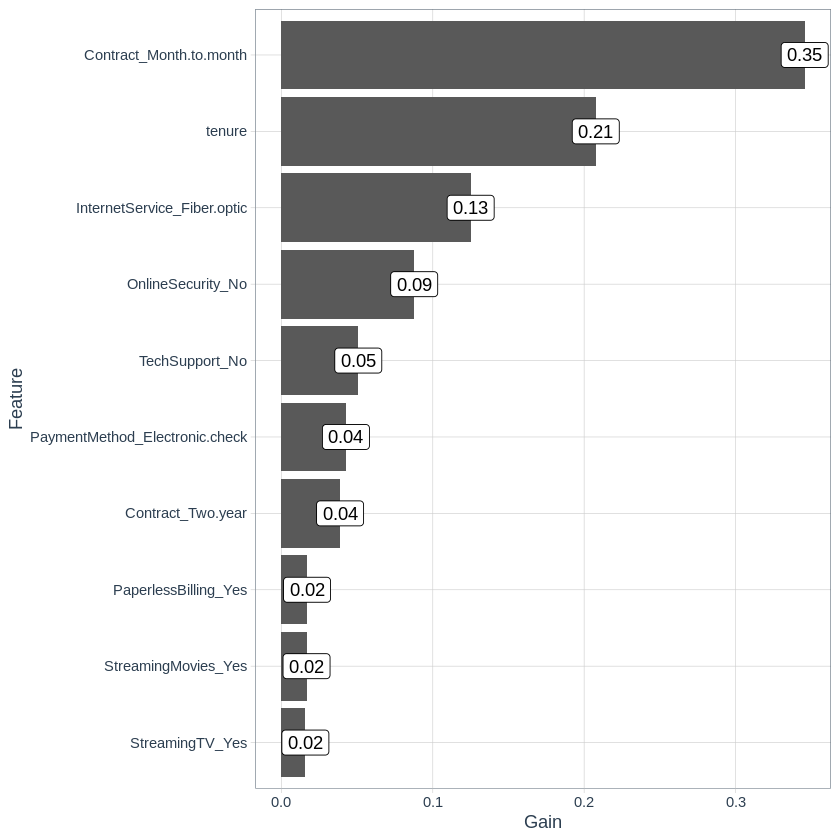

In [32]:
xgboost::xgb.importance(model = xgboost_model_final$fit) %>% 
    mutate(Feature = Feature %>% fct_reorder(Gain)) %>% 
    slice(1:10) %>% 
    ggplot(aes(x = Feature, y = Gain)) +
    geom_col() +
    geom_label(aes(label = round(Gain, 2))) +
    theme_tq() +
    coord_flip()

#### Results are along expected lines.
#### Next, in part 3 we will build a more accurate model with H2O AutoML.